In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sns.set()

In [2]:
raw_train = pd.read_csv('train.csv')
raw_test = pd.read_csv('test.csv')
titanic_train = pd.read_csv('train.csv')
titanic_test = pd.read_csv('test.csv')

# Exploratory Analysis

In [3]:
titanic_train.head()
# Survived: 0 = No, 1 = Yes
# Pclass: Ticket Class
# Sibsp: Number of siblings or spouses aboard the Titanic
# Parch: Number of parents or children aboard the Titanic
# Ticket: Ticket Number
# Cabin: Cabin Number
# Embarked: Where the passenger embarked. C = Cherbourg, Q = Queenstown, S = Southampton

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The first step is to explore some basic characteristics of our dataset to determine what may or may not be useful in the creation of our model.

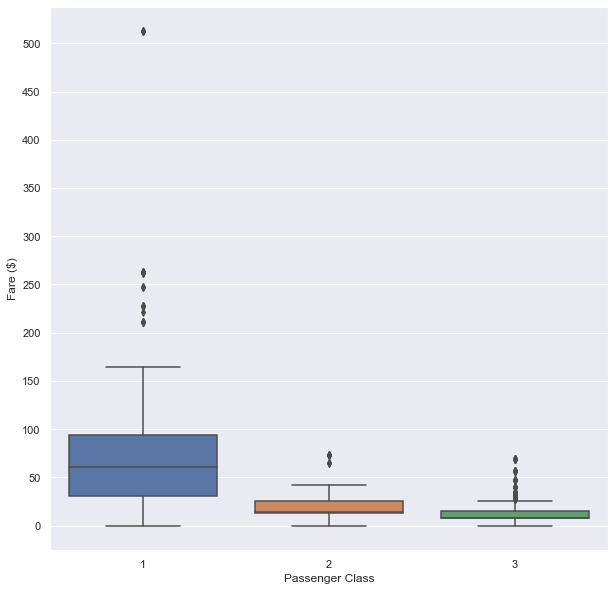

In [4]:
fig = plt.figure(figsize = (10,10))
sns.boxplot(x = 'Pclass', y = 'Fare', orient = 'v', data = titanic_train)
plt.xlabel('Passenger Class')
plt.ylabel('Fare ($)')
plt.yticks(np.arange(0,550,50))
plt.show()

For all three social classes, the bulk of values sit below $ 50-100. However, there are quite a few outliers in all three social classes. It would be interesting to see how a higher fare might influence survival likelihood (for example, perhaps it would indicate preferential cabin placement closer to the deck, which would make it easier to evacuate). 

Next, it would be interesting to see a the distribution of survivors based on age and sex. 

In [5]:
df_survivors = titanic_train[(titanic_train.Survived == 1)]
df_survivors.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


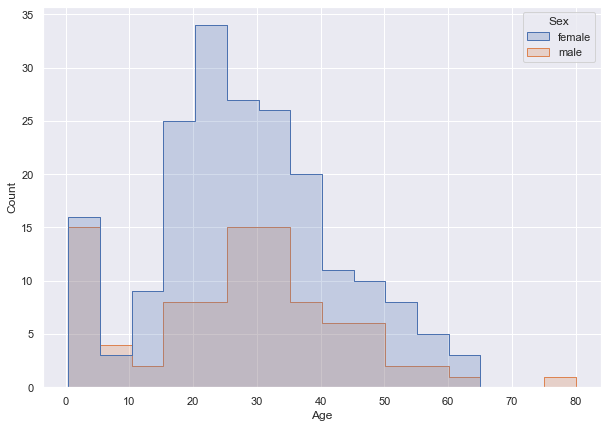

In [6]:
plt.figure(figsize = (10,7))
sns.histplot(x = 'Age', hue = 'Sex', element = 'step', data = df_survivors)
plt.show()

We see a multimodal histogram when examining the count of survivors from age. We see the first peak between 0-5 years of age. These are likely passengers who would be cared for and heavily supervised by older passengers.  The distributions sees a secondary peak between 20 and 30 years of age, which gradually descends as passengers get older.

The histogram also shows that far fewer men survived than women in age-ranges greater than 15-20 years of age. The distribution is really a testament to the statement 'women and children first'.

# Feature Engineering

In this next section, we will take a look at some new features we can create from the existing variables in the dataset.

First, our column cabin won't really be useful in our model. However, the cabin column contains information about which deck the passengers were located on. This can be done by extracting the first letter from the cabin column.

The Titanic had 10 decks in total, however passenger decks were located on decks B to G.

This could be useful information, since it could be more difficult for a passenger to evacuate if they were located on a lower deck.

Another interesting feature to create would be family size. 

This can easily be done by adding the columns SibSp and Parch (Siblings, Spouses, Parents, Children) together.

Finally, another interesting piece of information to look at would be the passenger's title. This can be extracted from the Name attribute.

In [7]:
def feature_engineering(df):
    # Deck = Leftmost character of cabin
    df['Deck'] = df['Cabin'].str[0]
    df['Deck'] = df['Deck'].fillna('Unknown')
    df = df.drop('Cabin', axis = 1)

    
    # Family Size = Siblings + Spouses + Parents + Children
    df['FamilySize'] = df['SibSp'] + df['Parch']
    df.drop(['SibSp','Parch'], axis = 1, inplace = True)
    
    #Extracting Title from Name
    df[['LastName','FirstName']] = df['Name'].str.split(', ', expand = True)
    df['Title'] = df['FirstName'].str.split('.').str[0]
    df.drop(['FirstName','LastName','Name'], axis = 1, inplace = True)
    
    return df

titanic_train = feature_engineering(titanic_train)
titanic_test = feature_engineering(titanic_test)

# Preprocessing The Data

Before we start building our model, we have to preprocess the data to avoid later issues.
We will start by examining null values in our dataset.

First, Embarked only has 2 null values. Since there won't be much data loss and accurate values are impossible to impute, we will just drop those rows.

In [8]:
titanic_train = titanic_train.dropna(subset = ['Embarked'],axis = 0)

In [9]:
titanic_test = titanic_test.dropna(subset = ['Fare'], axis = 0)

In [10]:
#Separating features and labels
titanic_train_features = titanic_train.drop('Survived', axis = 1)
titanic_train_labels = titanic_train['Survived'].copy()

In [11]:
titanic_train_features.isnull().sum(axis = 0)

PassengerId      0
Pclass           0
Sex              0
Age            177
Ticket           0
Fare             0
Embarked         0
Deck             0
FamilySize       0
Title            0
dtype: int64

Next, I want to restrict my training data to only relevant variables. For the purposes of this analysis, I will be removing PassengerId. I already dropped Cabin and Name in the Feature Engineering function, as both were used to create more useful variables (Deck, Title)

Next, I will handle the remainder of missing values, which occur in the age category. I'll start again by taking a look at the distribution of ages in our dataset to determine whether imputation of the mean or median is most appropriate for this variables

In [12]:
def data_preprocess(df):
    
    df['Age'].fillna(df['Age'].median(), inplace = True)
    
    #Log + 1 to avoid divide by zero error
    df['Logfare'] = np.log(df['Fare']+1)
    df = df.drop('Fare', axis = 1)
    
    df = df.drop('PassengerId', axis = 1)
    df = df.drop('Ticket', axis = 1)
    
    return df

titanic_train_features = data_preprocess(titanic_train_features)
titanic_test = data_preprocess(titanic_test)

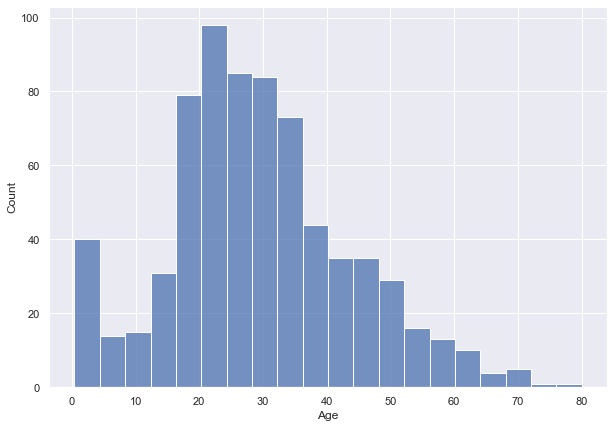

In [13]:
plt.figure(figsize = (10,7))
sns.histplot(x = 'Age', data = titanic_train)
plt.show()

The distribution is right skewed, with the bulk of values laying on the left of the histogram. This means that we will have a number of high value outliers that will inflate the mean. Therefore, because the distribution is so right skewed, I think that it would be more accurate to impute age with the median value than then the mean.

I also want to examine the distribution of fare to see if it would benefit from normalization.

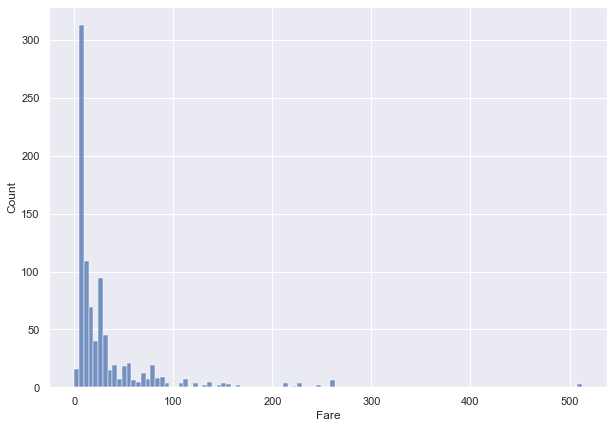

In [14]:
plt.figure(figsize = (10,7))
sns.histplot(x = 'Fare', data = titanic_train)
plt.show()

The distribution of fare is extremely right skewed. Therefore, I will try log transforming fare in an effort to later reduce the overall error of the model's predictions.

Note: I could not find a conclusive answer regarding 0 fare values online. 

I know that at least some of the 0 values were crew members who boarded in Southhampton and I do not have an explanation for the ones who were not crew members. Therefore, I don't feel entirely comfortable with completely removing or imputing the $0 values.

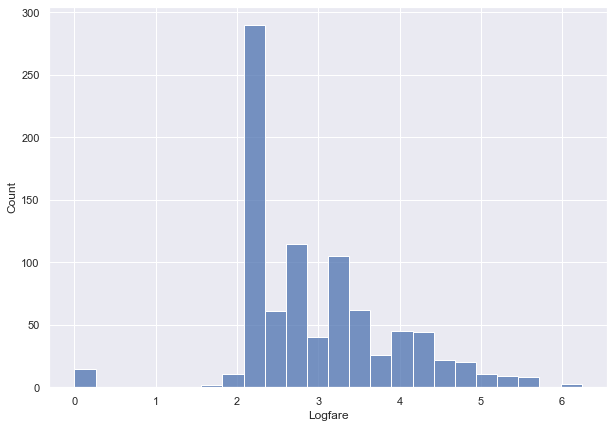

In [15]:
plt.figure(figsize = (10,7))
sns.histplot(x = 'Logfare', data = titanic_train_features)
plt.show()

This produces a more normalized version of fare that will likely be more useful in our model.

Next, I need to encode all categorical variables in my dataset in order to use them. I will be using One Hot Encoding for this project. 

We will use One Hot Encoding because normal Label Encoding assumes an ordinal relationship between levels in a given categorical column, which can lead to poor performance on the model. One Hot Encoding eliminates this problem by creating dummy variables for each level of a given categorical variable.

In [16]:
num_attributes = titanic_train_features.select_dtypes(exclude = 'object').columns
cat_attributes = titanic_train_features.select_dtypes(include = 'object').columns

Since the test data for this project doesn't have any labels, we will need to split our training set further to test out of sample performance of our model.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(titanic_train_features, titanic_train_labels, test_size = 0.2, 
                                                    random_state = 42)

In [18]:
full_pipeline = ColumnTransformer([
    ('std_scaler',StandardScaler(),num_attributes),
    ('ohe', OneHotEncoder(handle_unknown = 'ignore'), cat_attributes)
])

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

titanic_test_transformed = full_pipeline.transform(titanic_test)

# Building The Model

First, we have to select a model 

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

In [20]:
def display_scores(score):
    print('Scores: ', score)
    print('Mean', score.mean())
    print('Standard Deviation: ', score.std())

In [21]:
X_train = X_train.toarray()

In [22]:
def fit_models(features, labels):
    nb = GaussianNB()
    lgm = LogisticRegression()
    dtc = DecisionTreeClassifier()
    rfc = RandomForestClassifier()
    knc = KNeighborsClassifier()
    sgdc = SGDClassifier()
    
    model_list = [nb,lgm,dtc,rfc,knc,sgdc]
    
    for item in model_list:
        score = cross_val_score(item,features,labels,cv = 10, scoring = 'f1')
        print(f'{type(item).__name__}'.split('=')[0],'\n')
        display_scores(score)
        print('\n')

In [23]:
fit_models(X_train,y_train)

GaussianNB 

Scores:  [0.35       0.36363636 0.19354839 0.38888889 0.2        0.54054054
 0.24242424 0.19354839 0.42105263 0.42105263]
Mean 0.33146920728414786
Standard Deviation:  0.11300168219171126


LogisticRegression 

Scores:  [0.72727273 0.80701754 0.73076923 0.80701754 0.79245283 0.80769231
 0.7755102  0.79245283 0.72727273 0.76      ]
Mean 0.7727457945185282
Standard Deviation:  0.032272012224895126


DecisionTreeClassifier 

Scores:  [0.70588235 0.72413793 0.72       0.79245283 0.74576271 0.77777778
 0.76363636 0.71698113 0.77966102 0.74074074]
Mean 0.7467032857208251
Standard Deviation:  0.028705466976818354


RandomForestClassifier 

Scores:  [0.69387755 0.74576271 0.73076923 0.83636364 0.77777778 0.83636364
 0.70833333 0.75555556 0.75862069 0.76595745]
Mean 0.7609381569511668
Standard Deviation:  0.04486197233529316


KNeighborsClassifier 

Scores:  [0.72       0.82142857 0.76363636 0.85185185 0.76923077 0.81481481
 0.73913043 0.80851064 0.75862069 0.72      ]
Mean 0.77672

Logistic Regression and KNeighborsClassifier have the highest mean F1 scores. 

In [24]:
lgm = LogisticRegression()
lgm.fit(X_train,y_train)
predictions = lgm.predict(X_test)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       109
           1       0.76      0.80      0.78        69

    accuracy                           0.83       178
   macro avg       0.82      0.82      0.82       178
weighted avg       0.83      0.83      0.83       178



The model performs fairly well out of sample with 83% accuracy. Next we will look at optimizing the model.

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [27]:
parameter_grid = {'C': [0.01, 0.1, 1, 2, 10, 100],'solver' : ['liblinear','sag','saga'], 'penalty': ['l1','l2'],'max_iter' : [2000]}
gridsearch = GridSearchCV(lgm,parameter_grid,cv = 5, scoring = 'accuracy')
gridsearch.fit(X_train,y_train)
gridsearch.best_params_

C:\Users\Nickf\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Nickf\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nickf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Nickf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Val

{'C': 1, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}

In [28]:
randomsearch = RandomizedSearchCV(lgm,parameter_grid,cv = 5, scoring = 'accuracy')
randomsearch.fit(X_train,y_train)
randomsearch.best_params_

C:\Users\Nickf\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Nickf\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nickf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Nickf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Valu

{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 2000, 'C': 2}

In [29]:
lgm2 = LogisticRegression(C=10, penalty = 'l2', solver = 'liblinear', class_weight = 'balanced', max_iter  = 2000)
lgm2.fit(X_train,y_train)
predictions2 = lgm2.predict(X_test)
print(classification_report(y_test,predictions2))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82       109
           1       0.69      0.81      0.75        69

    accuracy                           0.79       178
   macro avg       0.78      0.79      0.78       178
weighted avg       0.80      0.79      0.79       178



The default parameters for our Logistic Regression model perform better than the tuned hyperparameters.

In [30]:
from sklearn.feature_selection import RFECV

lgm3 = LogisticRegression()
rfe = RFECV(estimator = lgm3, step = 1, cv = 10, scoring = 'accuracy')
fit = rfe.fit(X_train,y_train)

print("Num Features: %d" % fit.n_features_)

predictions3 = fit.predict(X_test)
print(classification_report(y_test,predictions3))

Num Features: 19
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       109
           1       0.76      0.80      0.78        69

    accuracy                           0.83       178
   macro avg       0.82      0.82      0.82       178
weighted avg       0.83      0.83      0.83       178



In [32]:
final_predictions = pd.Series(fit.predict(titanic_test_transformed))
titanic_test['Survived_pred'] = final_predictions

In [37]:
titanic_test

,Pclass,Sex,Age,Embarked,Deck,FamilySize,Title,Logfare,Survived_pred
0,3,male,34.5,Q,Unknown,0,Mr,2.178064,0.0
1,3,female,47.0,S,Unknown,1,Mrs,2.079442,1.0
2,2,male,62.0,Q,Unknown,0,Mr,2.369075,0.0
3,3,male,27.0,S,Unknown,0,Mr,2.268252,0.0
4,3,female,22.0,S,Unknown,2,Mrs,2.586824,1.0
...,...,...,...,...,...,...,...,...,...
413,3,male,27.0,S,Unknown,0,Mr,2.202765,1.0
414,1,female,39.0,C,C,0,Dona,4.699571,0.0
415,3,male,38.5,S,Unknown,0,Mr,2.110213,0.0
416,3,male,27.0,S,Unknown,0,Mr,2.202765,1.0
